In [ ]:
!pip install -U transformers
!pip install datasets
!pip install -U accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 5.1 MB/s eta 0:00:00


(CANNOT UPLOAD TO HUGGINGFACE IF YOU MOUNT DRIVE)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
#data = pd.read_csv('/content/drive/MyDrive/VIP: NLP for Financial Markets/CleanedConsumerResponseData.csv', engine='python', on_bad_lines='skip')
#data = pd.read_csv('/content/drive/MyDrive/School/Semester 5/NLP VIP/MultiClassClassification/CleanedConsumerResponseData.csv', engine='python', on_bad_lines='skip')
data = pd.read_csv('/content/equal_weight_complaint_sample.csv', engine='python', on_bad_lines='skip')

data.head()



,Consumer complaint narrative,Company response to consumer
0,"Consumer Portfolio Services , Inc XXXX XX...",Closed with explanation
1,In accordance with the Fair Credit Reporting a...,Closed with non-monetary relief
2,Navient pushed me to take forbearance on my lo...,Closed with explanation
3,This is one of several times I've discovered t...,Closed with non-monetary relief
4,"Several months ago, I opened a credit card acc...",Closed with monetary relief


<Axes: ylabel='Company response to consumer'>

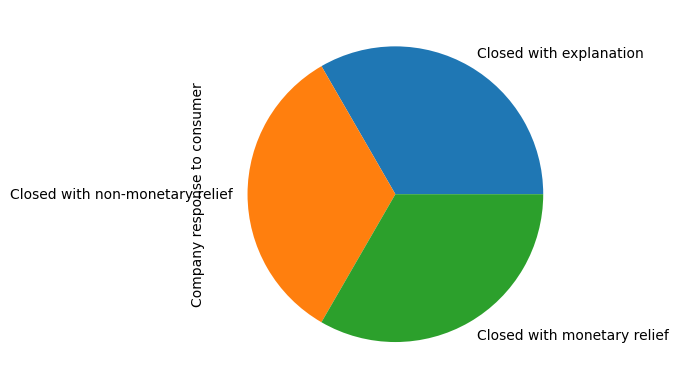

In [ ]:
data['Company response to consumer'].value_counts().plot(kind='pie')

# **Create Dataset Dictionary**
Seperate CSV to training and testing dataset

Dataset({
    features: ['Consumer complaint narrative', 'Company response to consumer', '__index_level_0__'],
    num_rows: 1200
})
Dataset({
    features: ['Consumer complaint narrative', 'Company response to consumer', '__index_level_0__'],
    num_rows: 2400
})
Dataset({
    features: ['Consumer complaint narrative', 'Company response to consumer', '__index_level_0__'],
    num_rows: 2400
})


<Axes: >

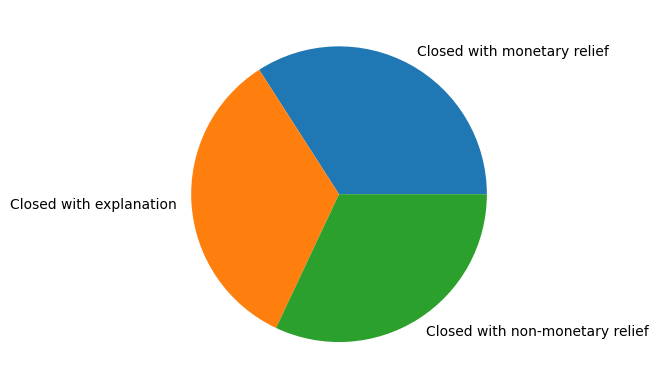

In [ ]:
from sklearn.model_selection import train_test_split
from datasets import Dataset
from datasets import DatasetDict

data_subset = data.head(6000)

train, test = train_test_split(data_subset, random_state=42, test_size=0.8, shuffle=True)

train_dataset = Dataset.from_pandas(train)
test_dataset = Dataset.from_pandas(test)

data_dict = DatasetDict({
    'train': train_dataset,
    'test': test_dataset
})

test_dataset = data_dict["test"].shard(num_shards=2, index=0)
val_dataset = data_dict['test'].shard(num_shards=2, index=1)

print(train_dataset)
print(test_dataset)
print(val_dataset)
pd.Series(train_dataset['Company response to consumer']).value_counts().plot(kind='pie')


# **Format Datasets**
Tokenize the complaints and change labels to numbers

In [ ]:
from transformers import AutoTokenizer, AutoConfig

BASE_MODEL = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)

unique_labels = data['Company response to consumer'].unique()
label2id = {label: i for i, label in enumerate(unique_labels)}
id2label = {i: label for label, i in label2id.items()}

def tokenize(batch):
    # Tokenize the consumer complaint narrative
    inputs = tokenizer(batch["Consumer complaint narrative"], padding=True, truncation=True, max_length=256)
    # Map the labels to their corresponding IDs
    inputs["label"] = [label2id[label] for label in batch["Company response to consumer"]]
    return inputs


train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)


# Update the format of the datasets
train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# Remove unnecessary columns
remove_columns = ['Consumer complaint narrative', 'Company response to consumer', '__index_level_0__']
train_dataset = train_dataset.remove_columns(remove_columns)
val_dataset = val_dataset.remove_columns(remove_columns)
test_dataset = test_dataset.remove_columns(remove_columns)

print(train_dataset)


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Map:   0%|          | 0/2400 [00:00<?, ? examples/s]

Map:   0%|          | 0/2400 [00:00<?, ? examples/s]

Dataset({
    features: ['input_ids', 'attention_mask', 'label'],
    num_rows: 1200
})


# **Train The Model**

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(output_dir=".",
                                  num_train_epochs=3,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=4,
                                  hub_model_id='CLindler/ConsumerResponseClassifier',
                                  remove_unused_columns=False,
                                  push_to_hub=False)

In [ ]:
from datasets import load_metric
import numpy as np

metric = load_metric("f1")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels, average="weighted")

<ipython-input-8-668ab9ccd2b7>:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("f1")


In [ ]:
from transformers import Trainer
from transformers import AutoModelForSequenceClassification


config = AutoConfig.from_pretrained(BASE_MODEL)
config.update({"id2label": id2label, 'num_labels': 3})
model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL, config=config)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_dataset[0]

{'input_ids': tensor([    0, 18622,    62,    31,   230,  9763,   387,  2870, 34528,  1000,
             6,    38,    21,   553,     7,   694,  6461,     9,   127,   592,
           573,   346,     6,  1241,  1028,   486,  2325, 26166,    73, 18313,
            73, 48193,     4, 11050,     7,   127,   284,     8,    38,   145,
          9871,     6,     8,  5506,     6,    36,   528,     7,     5,  1126,
            11,  4464, 31311,    38,   524,  3276,     7,  1325, 25778,     4,
            38,  5486,   127, 27620,     6,    25,    38,    40,  1950, 11866,
            11,   143,   233,     9,    42,   803,     6,     7,   120,    42,
          1126,  2928,     4,  1437, 50118, 50118,  3411,  5969, 26306, 15823,
         43362, 17831,    96, 34528,  1000,     9, 34528,  1000,     6,    38,
          4813,    10,  4464,     7, 34528,  1000,   136, 34528,  1000, 34528,
          1000, 34528,  1000,   128,  2120,     7,  5555,    10,  1126,    45,
         12942,     6,     9,    81, 25

In [ ]:
trainer.train()
evaluate_output = trainer.evaluate(test_dataset)
print(evaluate_output)

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
500,0.837600


# **Update Model on HuggingFace**

In [ ]:
from huggingface_hub import login, logout

login()

In [ ]:
tokenizer.push_to_hub("CLindler/ConsumerResponseClassifier")
trainer.push_to_hub()

CommitInfo(commit_url='https://huggingface.co/CLindler/ConsumerResponseClassifier/commit/777b5d6d425c3a87b029e0e8ef3138e2f0aabb2e', commit_message='Upload tokenizer', commit_description='', oid='777b5d6d425c3a87b029e0e8ef3138e2f0aabb2e', pr_url=None, pr_revision=None, pr_num=None)

# **Use the Model**

In [ ]:
from transformers import pipeline

predict_consumer_response = pipeline("text-classification", model="CLindler/ConsumerResponseClassifier")

response = predict_consumer_response('To Apply XXXX Credit to Account XXXX On XX/XX/2023, XXXX fraudulent charges ( XXXX for {$240.00} to XXXX, and XXXX for {$190.00} to Sanesolution ) totaling {$440.00} were made on our XXXX credit card. On XX/XX/XXXX The company ( XXXX ) resolved the dispute in our favor and credited our XXXX account. ( However, the XXXX account was deactivated due to the XXXX case ) so our new account XXXX still shows that fraud charge. We have been trying since XX/XX/XXXX to have the fraud charges removed from our XXXX account and was told that we would see the correction in the XX/XX/2023 statement. However the charge was still there. We were told they would request an investigation to correct the problem, but someone forget to include all the previous history, so the charge is still there. We have contacted them several since, with no result. Finally we were told on XX/XX/XXXX that the credit would be applied in XXXX to XXXX business days. However, not only did they not credit the account, they also added interest on the fraud charge. Please, help us resolve this matter as soon as possible. Thank You! Thank You!! Thank you!!!')

print(response)


[{'label': 'Closed with monetary relief', 'score': 0.9456703066825867}]
